In [16]:
import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import xarray as xr
import datetime
import timeit


# Load example Data

In [2]:
data2D = pd.read_csv('WEA_beispiel.csv', sep=';', header=0, index_col=0).dropna()
data2D = data2D.reindex(sorted(data2D.columns), axis=1)
data2D.head()

,0.95,0.975,1,1.025,1.05,1.075,1.1,1.125,1.15,1.175,1.2,1.225,1.25,1.275
3.0,51,54,57,60,62,65,68,70,73,76,79,81,84,87
3.5,123,127,132,136,141,145,150,154,159,163,168,172,177,181
4.0,210,217,224,231,238,244,251,258,265,272,278,285,292,299
4.5,318,328,337,347,357,366,376,386,395,405,415,424,434,444
5.0,452,465,478,492,505,518,531,544,557,571,584,597,610,623


# Interpolation

Interpolation is done using the scipy.interpolation package for both 1D and 2D interpolation of wind turbine power delivery data.
Examples for the here used methods can be found online:
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#d-spline-representation-object-oriented-bivariatespline

## 1D interpolation with scipy

In [ ]:
def interpolate1DWindturbineData(
    windTurbine_df: pd.Series,
    incrementWindspeed: float,
    interpolationMethod: str = 'cubic',
    plot: bool = True,
    powerLimiter: bool = True):
    """
    TO DO: 
    - return an interpolated pd.Dataframe of the same build
    """
    # Defining x and y arrays of the initial data set
    x = np.array(windTurbine_df.index)
    y = np.array(windTurbine_df.values)
    z = float(windTurbine_df.name)
    oldIncrement = round(x[1] - x[0],6)


    # x array that will be used for interpolating new point values
    steps = int(((x[-1] - x[0])/incrementWindspeed) + 1)

    x_new = np.linspace(x[0], x[-1], steps)
    increment = round(x_new[1] - x_new[0], 6)

    if interpolationMethod in ['linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'previous', 'next']:
        # Interpolation step
        f = interpolate.interp1d(x, y, kind = interpolationMethod)
        # y array that contains the interpolated data points
        y_interp = f(x_new)

    if powerLimiter:
        maxOriginalPower = y.max()
        y_interp[y_interp > maxOriginalPower] = maxOriginalPower

    if plot:
        fig = plt.figure(figsize=(10,6))
        ax = fig.subplots()
        ax.plot(x_new, y_interp, alpha = 0.5, label = interpolationMethod)
        ax.scatter(x,y)
        plt.xlabel(f"windspeed (m/s)\n increment increase: {oldIncrement} -> {increment}m/s")
        plt.ylabel("wind turbine power output (kW)")
        plt.legend()
        plt.show()

    return pd.Series(data=y_interp, name=z, index=x_new)

In [ ]:
data1D = data2D[data2D.columns[0]]

interpolate1DWindturbineData(
    windTurbine_df=data1D, 
    incrementWindspeed=0.001,
    interpolationMethod='cubic',
    plot=True,
    powerLimiter=True)

## 2D interpolation with scipy

In [ ]:
def calcSteps(
    top: float,
    bottom: float,
    increment: float,
    corrector: int = 1):
    """This function calculates the number of steps between a passed top and bottom value, based on a passed increment.

    Args:
        top(float): highest value of the intervall
        bottom(float): lowest value of the intervall
        incement(flaot): desired increment of intervall
        corrector(int): corrector value counting difference due to python starting with 0 instead of 1
    Return:
        Number of steps in the desired intervall
    """
    return complex((top-bottom)/increment + corrector)

def interpolate2DWindturbineData(
    windTurbine_df: pd.DataFrame,
    incrementWindspeed: float,
    incrementAirDensity: float,
    interpolationMethod: str = 'cubic',
    plot: bool = True,
    powerLimiter: bool = True,
    fill_to_zero: bool = False):
    """
    TO DO: 
    - change np.mgrid -> np.linespace in combination with np.meshgrid
    """
    # Building goal grid data based on min and max of passed windTurbine_df and increments for AirDensity and Windspeed
    x_orig = np.array(windTurbine_df.index)
    y_orig = np.array(windTurbine_df.columns, dtype='float')#.astype('float64')

    windMin = x_orig.min()
    windMax = x_orig.max()
    windSteps = calcSteps(top=windMax, bottom=windMin, increment=incrementWindspeed, corrector=1)

    densityMin = y_orig.min()
    densityMax = y_orig.max()
    densitySteps = calcSteps(top=densityMax, bottom=densityMin, increment=incrementAirDensity, corrector=2)

    grid_x, grid_y = np.mgrid[windMin:windMax:windSteps, densityMin:densityMax:densitySteps]


    # Prepare original windTurbine_df data for interpolation
    values = windTurbine_df.stack().values
    points = windTurbine_df.stack().index.values
    points = np.array([list(i) for i in points], dtype='float')


    # Interpolation based on passed interpolationMethod
    if interpolationMethod in ['nearest', 'linear', 'cubic']:
        grid_z = interpolate.griddata(points, values, (grid_x, grid_y), method=interpolationMethod)
    else:
        print('No valid interpolationMethod passed. Must be either: nearest, linear or cubic')
        pass


    # Clean interpolated data of "numerical-errors" from the interpolation in constant maximal areas
    if powerLimiter:
        maxOriginalPower = values.max()
        grid_z[grid_z > maxOriginalPower] = maxOriginalPower

    if fill_to_zero:
        pass#np.arange(0,windMin,incrementWindspeed)


    # Plotting base 
    if plot:
        # Set up a figure twice as wide as it is tall
        fig = plt.figure(figsize=(20,10))
        colormap = cm.coolwarm #viridis


        #===============
        #  First subplot
        #===============
        # Set up the axes for the first plot
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        # Original data split coordinate wise
        X_orig, Y_orig = np.meshgrid(x_orig, y_orig)
        Z = windTurbine_df.values.transpose()
        
        # Plot original data
        ax.plot_wireframe(X_orig, Y_orig, Z, linewidth=0.7)#, rstride=10, cstride=10)
        ax.contour(X_orig, Y_orig, Z, zdir='z', offset=10, cmap=colormap, alpha=0.9)
        ax.set_title('initial\nwind turbine data')
        ax.set_xlabel('windspeed (m/s)')
        ax.set_ylabel('air density (kg/m³)')
        ax.set_zlabel('power output (kW)')


        #===============
        # Second subplot
        #===============
        # Set up the axes for the second plot
        ax = fig.add_subplot(1, 2, 2, projection='3d')

        # Plot interpolated data with original data as reference
        ax.plot_surface(grid_x, grid_y, grid_z, cmap=colormap, alpha=0.7, edgecolor='none')
        ax.scatter(points.transpose()[0], points.transpose()[1], values, marker='o', color='k', s=7)
        ax.contourf(grid_x, grid_y, grid_z, zdir='z', offset=-100, cmap=colormap, alpha=0.5)
        ax.set_title('interpolated\nwind turbine data')
        ax.set_xlabel('windspeed (m/s)')
        ax.set_ylabel('air density (kg/m³)')
        ax.set_zlabel('power output (kW)')

    return pd.DataFrame(data=grid_z, columns=grid_y[0], index=grid_x.transpose()[0])


In [ ]:
interpolate2DWindturbineData(
    windTurbine_df=data2D, 
    incrementWindspeed=0.01, 
    incrementAirDensity=0.001, 
    interpolationMethod='cubic', 
    plot=True, 
    powerLimiter=True)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')

windMin = data2D.index.min()
windMax = data2D.index.max()
pressureMin = min([float(i) for i in data2D.columns])
pressureMax = max([float(i) for i in data2D.columns])

grid_x, grid_y = np.mgrid[windMin:windMax:250j, pressureMin:pressureMax:50j]

values = data2D.stack().values
points = data2D.stack().index.values
points = np.array([list(i) for i in points], dtype='float')

grid_z0 = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = interpolate.griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')

points = data2D.stack().index.values
points = np.array([list(i) for i in points], dtype='float')

xs_old = points.transpose()[0]
xs = grid_x.flatten()
ys_old = points.transpose()[1]
ys = grid_y.flatten()

zs_old = data2D.stack().values
zs = grid_z2.flatten()

ax.scatter(xs, ys, zs, marker='.', alpha=0.3)
#ax.plot_surface(xs, ys, zs, rstride=8, cstride=8, alpha=0.3)
ax.scatter(xs_old, ys_old, zs_old, marker='o', alpha=0.6, color='r', s=7)

ax.set_xlabel('windspeed (m/s)')
ax.set_ylabel('air density ()')
ax.set_zlabel('power output')

plt.show()

# Transforming the *Leistungskennlinie* to a *Windatlas* compatible format

In [42]:
data_vars={'leistung':(['wspd','rho'], np.array(data2D), 
                        {'units': 'kWh',
                        'long_name':'Leistung aus Wind und Luftdichte'})}

coords = {
        "wspd": (["wspd"], np.array(data2D.index, dtype="float64")),
        "rho": (["rho"], np.array(data2D.columns, dtype="float64")),
        }

attrs = {'describtion':"interpolated Leistungskennlinie",
        'creation_date':datetime.date.today(), 
        'author':'Claudius Wehner'}

test2D = xr.DataArray(
    data=np.array(data2D),
    coords=coords,
    attrs=attrs
)
test2D

<xarray.DataArray (wspd: 44, rho: 14)>
array([[  51,   54,   57,   60,   62,   65,   68,   70,   73,   76,   79,
          81,   84,   87],
       [ 123,  127,  132,  136,  141,  145,  150,  154,  159,  163,  168,
         172,  177,  181],
       [ 210,  217,  224,  231,  238,  244,  251,  258,  265,  272,  278,
         285,  292,  299],
       [ 318,  328,  337,  347,  357,  366,  376,  386,  395,  405,  415,
         424,  434,  444],
       [ 452,  465,  478,  492,  505,  518,  531,  544,  557,  571,  584,
         597,  610,  623],
       [ 616,  633,  651,  669,  686,  704,  721,  739,  757,  774,  792,
         809,  827,  844],
       [ 813,  835,  858,  881,  904,  926,  949,  972,  995, 1017, 1040,
        1062, 1085, 1108],
       [1045, 1074, 1103, 1131, 1160, 1189, 1218, 1247, 1275, 1304, 1332,
        1361, 1389, 1418],
       [1317, 1353, 1389, 1425, 1461, 1496, 1532, 1568, 1603, 1639, 1674,
        1709, 1744, 1779],
       [1628, 1671, 1715, 1758, 1802, 1845, 1888, 1931, 1974, 2016, 2058,
        2101, 2143, 2185],
...
       [4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200,
        4200, 4200, 4200],
       [4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186,
        4186, 4186, 4186],
       [3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870,
        3870, 3870, 3870],
       [3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373,
        3373, 3373, 3373],
       [2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745,
        2745, 2745, 2744],
       [2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154,
        2154, 2154, 2154],
       [1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805,
        1805, 1805, 1805],
       [1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526,
        1526, 1526, 1526],
       [1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283,
        1283, 1283, 1283],
       [1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
        1116, 1116, 1116]])
Coordinates:
  * wspd     (wspd) float64 3.0 3.5 4.0 4.5 5.0 5.5 ... 22.5 23.0 23.5 24.0 24.5
  * rho      (rho) float64 0.95 0.975 1.0 1.025 1.05 ... 1.2 1.225 1.25 1.275
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-01-19
    author:         Claudius Wehner

Text(0.5, 1.0, 'Interpolated data')

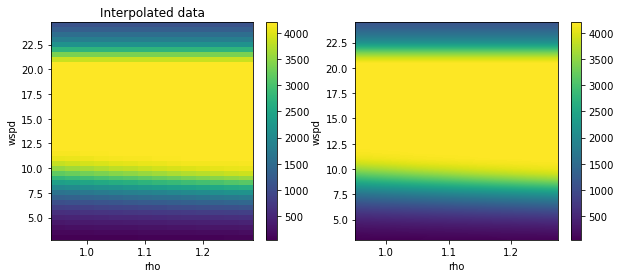

In [45]:
import matplotlib.pyplot as plt

data_vars={'leistung':(['wspd','rho'], np.array(data2D), 
                        {'units': 'kWh',
                        'long_name':'Leistung aus Wind und Luftdichte'})}

coords = {
        "wspd": (["wspd"], np.array(data2D.index, dtype="float64")),
        "rho": (["rho"], np.array(data2D.columns, dtype="float64")),
        }

attrs = {'describtion':"interpolated Leistungskennlinie",
        'creation_date':datetime.date.today(), 
        'author':'Claudius Wehner'}

test2D = xr.Dataset(
    data_vars=data_vars,
    coords=coords,
    attrs=attrs
)

testarray2D = xr.DataArray(
    data=np.array(data2D),
    coords=coords,
    attrs=attrs
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
testarray2D.plot(ax=axes[0])
axes[0].set_title("Raw data")

increment_wspd = 0.001
increment_rho = 0.0001
new_wspd = np.arange(testarray2D.wspd[0], testarray2D.wspd[-1]+increment_wspd, increment_wspd)
new_rho = np.arange(testarray2D.rho[0], testarray2D.rho[-1]+increment_rho, increment_rho)
testarray2Di = testarray2D.interp(wspd=new_wspd, rho=new_rho, method="linear")

testarray2Di.plot(ax=axes[1])
axes[0].set_title("Interpolated data")

In [49]:
testarray2Di.loc[dict(wspd=slice(24.498),rho=slice(1.2749))].plot

<xarray.DataArray (wspd: 21499, rho: 3250)>
array([[  51.      ,   51.012   ,   51.024   , ...,   86.964   ,
          86.976   ,   86.988   ],
       [  51.144   ,   51.156008,   51.168016, ...,   87.151976,
          87.163984,   87.175992],
       [  51.288   ,   51.300016,   51.312032, ...,   87.339952,
          87.351968,   87.363984],
       ...,
       [1117.336   , 1117.336   , 1117.336   , ..., 1117.336   ,
        1117.336   , 1117.336   ],
       [1117.002   , 1117.002   , 1117.002   , ..., 1117.002   ,
        1117.002   , 1117.002   ],
       [1116.668   , 1116.668   , 1116.668   , ..., 1116.668   ,
        1116.668   , 1116.668   ]])
Coordinates:
  * wspd     (wspd) float64 3.0 3.001 3.002 3.003 3.004 ... 24.49 24.5 24.5 24.5
  * rho      (rho) float64 0.95 0.9501 0.9502 0.9503 ... 1.275 1.275 1.275 1.275
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-01-19
    author:         Claudius Wehner

In [182]:
wspd = np.around(np.random.uniform(float(test2D.wspd.min()), float(test2D.wspd.max()), size=(600000)),1)
rho = np.around(np.random.uniform(float(test2D.rho.min()), float(test2D.rho.max()), size=(600000)),3)
start = timeit.default_timer()
dummy = testarray2Di.sel(
    wspd=xr.DataArray(wspd, dims='z'), 
    rho=xr.DataArray(rho, dims='z'), 
    method="nearest")#.values
end = timeit.default_timer()
timed = end - start
del(wspd)
del(rho)
print(f'Time to find get point data: {timed}')
dummy#[:100]

Time to find get point data: 0.3820166520308703


<xarray.DataArray (z: 600000)>
array([1322.8 ,  935.76, 2548.92, ..., 4200.  , 2868.16,  981.  ])
Coordinates:
    wspd     (z) float64 6.4 5.8 8.0 20.4 5.4 12.4 ... 14.1 17.8 18.8 8.5 6.2
    rho      (z) float64 1.245 1.194 1.227 1.176 ... 1.103 1.119 1.159 1.025
Dimensions without coordinates: z
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-01-19
    author:         Claudius Wehner

<AxesSubplot:xlabel='z'>

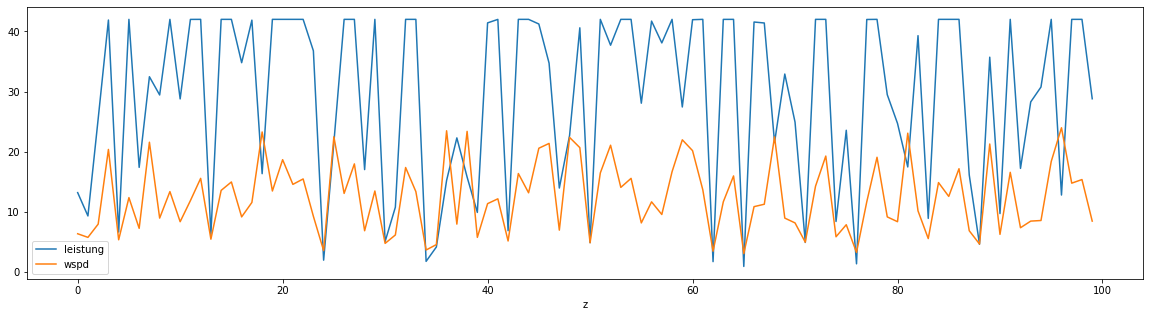

In [200]:
df = dummy.to_pandas().to_frame()
df = df.rename({0: "leistung"}, axis=1)
df["wspd"] = dummy.wspd.values
df.loc[:,"leistung"] = df["leistung"] /100
df.head(n=100).plot(figsize=(20,5))

In [ ]:
data = interpolate2DWindturbineData(
    windTurbine_df=data2D, 
    incrementWindspeed=0.01, 
    incrementAirDensity=0.0001, 
    interpolationMethod='linear', 
    plot=False, 
    powerLimiter=True)

In [ ]:
#data = data2D
test2 = xr.DataArray(
    np.array(data),
    dims=("wspd", "rho"), 
    coords={
        "wspd": np.array(data.index),
        "rho": np.array(data.columns),
        },
    attrs=dict(description="interpolated Leistungskennlinie"),
)

test = xr.Dataset(
    data_vars={
        "leistung": (("wspd", "rho"), np.array(data)),
        },
    coords={
        "wspd": np.array(data.index),
        "rho": np.array(data.columns),
        #"turbine": (),
        },
    attrs=dict(description="interpolated Leistungskennlinie"),
)

In [ ]:
wspd = round(np.random.uniform(float(test.wspd.min()), float(test.wspd.max())),2)
rho = round(np.random.uniform(float(test.rho.min()), float(test.rho.max())),4)
test#.sel(wspd=wspd, rho=rho)

In [ ]:
test.rho.load()
